---
# Deep Q-Learning

In this assignment, you will implement DQN for deep reinforcement learning from high-dimensional observations.

As in previous assignments, you will see code blocks that look like this:
```python
###############################################################################
# TODO: Create a variable x with value 536.                                   #
###############################################################################
# Replace "pass" statement with your code
pass
# END OF YOUR CODE
```

You should replace the `pass` statement with your own code and leave the blocks intact, like this:
```python
###############################################################################
# TODO: Create a variable x with value 536.                                   #
###############################################################################
# Replace "pass" statement with your code
x = 536
# END OF YOUR CODE
```

Also, please remember:
- Do not write or modify any code outside of code blocks unless otherwise stated.
- Do not delete any cells from the notebook. You may add new cells to perform scratch work, but delete them before submitting.
- Run all cells before submitting. You will only get credit for code that has been run.
- Submit your notebook as `netid.ipynb`, where `netid` is your actual netid.
- Your submission will be graded with PyTorch 1.7.0 and Python 3.6, which are the default versions in Google Colab.

In [1]:
from __future__ import print_function
from __future__ import division

import math
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
assert torch.cuda.is_available(), 'GPU unavailable'

## Toy Environment

We first introduce a toy environment that we can use to test our implementation quickly:

- **4 states**: 0, 1, 2, 3. Each state corresponds to an observation of shape $84 \times 84 \times 4$.
- **5 actions**: 0, 1, 2, 3, 4. Action $0 \le i \le 3$ goes straight to state $i$. Action 4 makes the agent stay in the same state.
- **Rewards**: Going to state $i$ from states 0, 1, and 3 gives a reward $R(i)$, where $R(0)=0.1$, $R(1)=-0.2$, $R(2)=0$, and $R(3)=-0.1$. If we start in state 2, then the rewards defined above are multiplied by -20. The discount rate $\gamma=1$.
- **Episode length**: One episode lasts 5 timesteps (for a total of 5 actions) and always starts in state 0 (no rewards at the initial state).

For example, one episode may have the following actions: 1, 2, 4, 3, 0. This would result in the following states: 0 (initial), 1, 2, 2, 3, 0. And the following rewards: -0.2, 0, 0, 2, 0.1.

What is the maximum sum of rewards that can be achieved in a single episode? Assign your answer to the variable `max_reward`. Also, provide an `action_sequence` of length 5 that achieves the maximum sum of rewards.

In [3]:
#########################################################################
# TODO:                                                                 #
# Set `max_reward` to the maximum sum of rewards that can be achieved   #
# in a single episode in the above toy environment.                     #
#########################################################################
max_reward = 8.1

In [4]:
# Hidden test cell for `max_reward`. Do not delete.

In [5]:
#########################################################################
# TODO:                                                                 #
# Set `action_sequence` to a sequence of 5 actions that achieves        #
# the maximum sum of rewards in the above toy environment.              #
#########################################################################
action_sequence = [2,1,2,1,0]

assert len(action_sequence) == 5

In [6]:
# Hidden test cell for `action_sequence`. Do not delete.

Below is an implementation of the above toy environment. It has the same interface as [OpenAI Gym](https://gym.openai.com/), so hopefully what you implement in this assignment can also be used for the various environments available in OpenAI Gym.

In [7]:
class ObservationSpace():

    def __init__(self, shape=(84, 84, 4)):
        self.shape = shape
        self.state_0 = np.random.randint(0, 30, shape, dtype=np.uint8)
        self.state_1 = np.random.randint(60, 90, shape, dtype=np.uint8)
        self.state_2 = np.random.randint(120, 150, shape, dtype=np.uint8)
        self.state_3 = np.random.randint(180, 210, shape, dtype=np.uint8)
        self.states = [self.state_0, self.state_1, self.state_2, self.state_3]


class ActionSpace():

    def __init__(self, n=5):
        self.n = n

    def seed(self, seed):
        # no-op
        self.seed=0

    def sample(self):
        return np.random.randint(0, self.n)


class ToyEnv():

    def __init__(self, shape=(84, 84, 4)):
        self.observation_space = ObservationSpace(shape)
        self.action_space = ActionSpace(5)
        self.rewards = [0.1, -0.2, 0.0, -0.1]
        self.cur_state = 0
        self.num_steps = 0
        self.was_in_state_2 = False

    def seed(self, seed):
        # no-op
        self.seed=0

    def reset(self):
        self.cur_state = 0
        self.num_steps = 0
        self.was_in_state_2 = False
        return self.observation_space.states[self.cur_state]

    def step(self, action):
        assert action in range(5), 'invalid action'
        self.num_steps += 1
        if action < 4:
            self.cur_state = action
        reward = self.rewards[self.cur_state]
        if self.was_in_state_2:
            reward *= -20
        if self.cur_state == 2:
            self.was_in_state_2 = True
        else:
            self.was_in_state_2 = False
        return self.observation_space.states[self.cur_state], reward, self.num_steps >= 5, {}

    def render(self):
        print(self.cur_state)

## Q-Network

The Q-network takes in the observation corresponding to a state $s$, and outputs the action-value $Q(s, a)$ for each valid action $a$. The input is a FloatTensor of shape $(\text{batch_size}, 84, 84, \text{in_channels})$, and the output is a FloatTensor of shape $(\text{batch_size}, \text{num_actions})$. You may use the architecture described in the [paper](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf).

In [8]:
class ReshapeImage(nn.Module):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        if len(x.shape) < 4:
            x = x[None, ...]
        x = x.permute(0, 3, 1, 2).contiguous()
        return x


def create_q_network(in_channels, num_actions):
    
    return nn.Sequential(
        ReshapeImage(),
        #########################################################################
        # TODO:                                                                 #
        # Implement the Q-network.                                              #
        #########################################################################
        # Replace "pass" statement with your code
        nn.Conv2d(in_channels=in_channels, out_channels= 32 , kernel_size=3),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels= 64 , kernel_size=2),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels= 20 , kernel_size=3),
        nn.ReLU(),
        nn.Flatten(start_dim=1), 
        nn.Linear(6480, 100),
        nn.ReLU(),
        nn.Linear(100, 20),
        nn.ReLU(),
        nn.Linear(20,num_actions)
        

        # END OF YOUR CODE
    )

## $\epsilon$-Greedy Behavior Policy

Q-learning is off-policy, which means the transitions are collected by a behavior policy that is different from the target policy we are trying to optimize. The behavior policy used in DQN is $\epsilon$-greedy, with $\epsilon$ annealed linearly from 1.0 to 0.1. Implement `LinearSchedule` below, which linearly anneals the `value` from `value_begin` to `value_end` over `nsteps`.

In [9]:
class LinearSchedule():
    
    def __init__(self, value_begin, value_end, nsteps):
        self.value_begin = value_begin
        self.value_end = value_end
        self.nsteps = nsteps
        
        # current value
        self.value = value_begin
    
    def update(self, t):
        #########################################################################
        # TODO:                                                                 #
        # Modify self.value such that it is a linear interpolation from         #
        # self.value_begin to self.value_end as t goes from 0 to self.nsteps.   #
        # For t > self.nsteps, self.value = self.value_end.                     #
        #########################################################################
        # Replace "pass" statement with your code
        
        factor = min(float(t)/self.nsteps, 1.0)
        self.value = max(self.value_end, self.value_begin + factor * (self.value_end - self.value_begin))
        # END OF YOUR CODE

The `BehaviorPolicy` can now be implemented as a subclass of `LinearSchedule`.

In [10]:
class BehaviorPolicy(LinearSchedule):
    
    def __init__(self, env, value_begin, value_end, nsteps):
        super().__init__(value_begin, value_end, nsteps)
        self.env = env
    
    def get_action(self, best_action):
        """
        With probability self.value, returns a random action; otherwise returns best_action.
        """
        if np.random.random() < self.value:
            return self.env.action_space.sample()
        else:
            return best_action

## Experience Replay

DQN uses experience replay to stabilize training. It stores the transitions into a replay buffer, and samples mini-batches from the buffer to apply Q-learning updates. An implementation of `ReplayBuffer` is provided below. You need to implement the `sample` function that samples a mini-batch of transitions. You may want to read through the code to understand what it is doing.

In [11]:
class ReplayBuffer():
    
    def __init__(self, size, frame_history_len):
        """
        An implementation of the replay buffer.
        
        Parameters
        ----------
        size: int
            Max number of frames to store in the buffer. When the buffer is full,
            the oldest frames are dropped first.
        frame_history_len: int
            Number of consecutive frames to use for each observation.
        """
        self.size = size
        self.frame_history_len = frame_history_len
        
        self.next_idx = 0
        self.num_frames_in_buffer = 0
        
        self.obs    = None
        self.action = None
        self.reward = None
        self.done   = None
    
    def store_frame(self, frame):
        """
        Stores a single frame into the buffer at the next available index, overwriting
        old frames if necessary.
        
        Parameters
        ----------
        frame: np.array of shape (img_h, img_w, img_c) and dtype np.uint8
            The frame to be stored.
        """
        if self.obs is None:
            self.obs    = np.empty([self.size] + list(frame.shape), dtype=np.uint8)
            self.action = np.empty([self.size],                     dtype=np.int32)
            self.reward = np.empty([self.size],                     dtype=np.float32)
            self.done   = np.empty([self.size],                     dtype=np.bool)
        
        idx = self.next_idx
        self.obs[idx] = frame
        
        self.next_idx = (idx + 1) % self.size
        self.num_frames_in_buffer = min(self.size, self.num_frames_in_buffer + 1)
    
    def store_effect(self, action, reward, done):
        """
        Stores the effects of the `action`.
        
        Parameters
        ----------
        action: int
            Action taken upon last observation.
        reward: float
            Reward received from taking the action.
        done: bool
            True if the episode terminates after taking the action.
        """
        idx = (self.next_idx - 1) % self.size
        self.action[idx] = action
        self.reward[idx] = reward
        self.done[idx]   = done
    
    def get_observation(self):
        """
        Returns the most recent `frame_history_len` frames, to be used as
        input to the Q-network.
        
        Returns
        -------
        observation: np.array of shape (img_h, img_w, frame_history_len * img_c)
            and dtype np.uint8
        """
        assert self.num_frames_in_buffer > 0
        return self._get_frame_history((self.next_idx - 1) % self.size)
    
    def _get_frame_history(self, end_idx):
        end_idx = end_idx + 1  # make `end_idx` exclusive
        start_idx = end_idx - self.frame_history_len
        
        if start_idx < 0 and self.num_frames_in_buffer < self.size:
            # not enough frames in buffer
            start_idx = 0
        
        # avoid mixing different episodes
        for idx in range(start_idx, end_idx - 1):
            if self.done[idx % self.size]:
                start_idx = idx + 1
        
        num_missing_frames = self.frame_history_len - (end_idx - start_idx)
        if start_idx < 0 or num_missing_frames > 0:
            pad = [np.zeros_like(self.obs[0]) for _ in range(num_missing_frames)]
            frames = pad + [self.obs[idx % self.size] for idx in range(start_idx, end_idx)]
            return np.concatenate(frames, 2)
        else:
            img_h, img_w = self.obs.shape[1], self.obs.shape[2]
            return self.obs[start_idx : end_idx].transpose(1, 2, 0, 3).reshape(img_h, img_w, -1)
    
    def _can_sample(self, batch_size):
        """
        Returns True if `batch_size` different transitions can be sampled from the buffer.
        """
        if self.num_frames_in_buffer < self.size:
            return batch_size + 1 <= self.num_frames_in_buffer
        else:
            return batch_size + self.frame_history_len <= self.size
    
    def sample(self, batch_size):
        """
        Samples `batch_size` different transitions.
        
        The i-th sampled transition is the following:
        
        When observing `obs_batch[i]`, the agent took action `act_batch[i]`,
        after which reward `rew_batch[i]` was received and subsequent
        observation `next_obs_batch[i]` was obtained, unless the episode
        was done which is represented by `done_mask[i]`. That is,
        done_mask[i] = 1.0 if the episode terminates after taking the action.
        
        Parameters
        ----------
        batch_size: int
            Number of transitions to sample.
        
        Returns
        -------
        obs_batch: np.array of shape (batch_size, img_h, img_w, frame_history_len * img_c)
            and dtype np.uint8
        act_batch: np.array of shape (batch_size,) and dtype np.int32
        rew_batch: np.array of shape (batch_size,) and dtype np.float32
        next_obs_batch: np.array of shape (batch_size, img_h, img_w, frame_history_len * img_c)
            and dtype np.uint8
        done_mask: np.array of shape (batch_size,) and dtype np.float32
        """
        assert self._can_sample(batch_size)
        #########################################################################
        # TODO:                                                                 #
        # Sample a batch of different transitions.                              #
        #########################################################################
        
        indices = []
        for _ in range(batch_size):
          div_idx = random.randint(0, self.num_frames_in_buffer - 2)
          if div_idx not in indices:
            indices.append(div_idx)
        obs_batch      = np.concatenate([self._get_frame_history(idx)[np.newaxis, :] for idx in indices], 0)
        act_batch      = self.action[indices]
        rew_batch      = self.reward[indices]
        next_obs_batch = np.concatenate([self._get_frame_history(idx + 1)[np.newaxis, :] for idx in indices], 0)
        done_mask      = np.array([self.done[idx] for idx in indices], dtype=np.float32)

        return obs_batch, act_batch, rew_batch, next_obs_batch, done_mask

## DQN Training

Implement Algorithm 1 in the [paper](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf). Make sure to use `with torch.no_grad()` or `detach()` to block unwanted gradient flow.

In [12]:
class DQN:
    
    def __init__(self, env, config):
        self.env = env
        self.config = config
        
        self.replay_buffer = ReplayBuffer(config['buffer_size'], config['frame_history_len'])
        self.behavior = BehaviorPolicy(env, config['eps_begin'], config['eps_end'], config['eps_nsteps'])
        
        self.q_net = None
        self.q_net_target = None
        self.optimizer = None
        #########################################################################
        # TODO:                                                                 #
        # Initialize the Q-network `self.q_net`, target Q-network               #
        # `self.q_net_target`, and optimizer.                                   #
        #########################################################################
        # Replace "pass" statement with your code
        self.q_net = create_q_network(env.observation_space.shape[2]*config['frame_history_len'], env.action_space.n).to(config['device'])
        self.q_net_target = create_q_network(env.observation_space.shape[2]*config['frame_history_len'], env.action_space.n).to(config['device'])
        # self.q_net_target.load_state_dict(self.q_net.state_dict())
        self.optimizer = optim.RMSprop(self.q_net.parameters(), lr=config['lr'])
        # END OF YOUR CODE
    
    def _update_target_params(self):
        """
        Updates `self.q_net_target` parameters by copying parameters from `self.q_net`.
        """
        with torch.no_grad():
            self.q_net_target.load_state_dict(self.q_net.state_dict())
    
    def train(self):
        t = 0  # total number of actions taken
        rewards = []  # to store the cumulative reward for each episode
        while t < self.config['train_nsteps']:
            gamma = 1.
            total_reward = 0.
            
            # start a new episode
            state = self.env.reset()
            self.replay_buffer.store_frame(state)
            
            # while episode does not terminate
            while True:
                # get `frame_history_len` most recent frames
                # as an input observation to the Q-network
                q_input = self.replay_buffer.get_observation()
                q_input = torch.from_numpy(q_input).to(self.config['device']).float()
                
                action = None
                #########################################################################
                # TODO:                                                                 #
                # Use the behavior policy to select action.                             #
                # You may directly use `q_input` as \phi(s_t) in the paper.             #
                #########################################################################
                # Replace "pass" statement with your code
                out = self.q_net(q_input)
                _, actions= torch.max(out, dim=1)
                self.behavior.update(t)
                action = self.behavior.get_action(actions.item())
                # END OF YOUR CODE
                
                # execute action and store transition
                new_state, reward, done, info = self.env.step(action)
                self.replay_buffer.store_effect(action, reward, done)
                if not done:
                    state = new_state
                    self.replay_buffer.store_frame(state)
                
                if t >= self.config['learning_start']:
                    #########################################################################
                    # TODO:                                                                 #
                    # Sample a mini-batch of transitions from the replay buffer,            #
                    # and perform a gradient descent step on `self.q_net`.                  #
                    #########################################################################
                    # Replace "pass" statement with your code
                    obs_batch, act_batch, rew_batch, next_obs_batch, done_mask = self.replay_buffer.sample(self.config['batch_size'])
                    obs_batch = torch.tensor(obs_batch).to(config['device']).float()
                    act_batch = torch.tensor(act_batch).to(config['device']).long()
                    rew_batch = torch.tensor(rew_batch).to(config['device']).float()
                    next_obs_batch = torch.tensor(next_obs_batch).to(config['device']).float()
                    done_mask_n = torch.tensor(1-done_mask).to(config['device']).float()

                    out = self.q_net(obs_batch).gather(1,act_batch.unsqueeze(1))
                    out_target = torch.max(self.q_net_target(next_obs_batch), dim=1)
                    out_target = rew_batch + (gamma*done_mask_n*out_target[0])
                    loss = torch.sum((out_target - out.squeeze())**2)

                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    # END OF YOUR CODE
                    
                    # periodically update the target network
                    if (t + 1 - self.config['learning_start']) % self.config['target_update_freq'] == 0:
                        self._update_target_params()
                
                # cumulative reward
                total_reward += gamma * reward
                gamma *= self.config['gamma']
                
                t += 1
                if done or t >= self.config['train_nsteps']:
                    break
            
            # end of episode
            if done:
                rewards.append(total_reward)
                print(f'step: {t} \t epsilon: {self.behavior.value:.4f} \t cumulative reward: {total_reward: .1f}')
        
        return rewards

In [13]:
def run(config):
    
    random.seed(config['seed'])
    np.random.seed(config['seed'])
    torch.manual_seed(config['seed'])
    
    env = config['env']()
    env.seed(config['seed'])
    env.action_space.seed(config['seed'])
    
    dqn = DQN(env, config)
    
    rewards = dqn.train()
    return dqn, rewards

In [14]:
config = {
    'seed': 0,
    'device': 'cuda',
    
    'env': ToyEnv,
    'gamma': 1.0,
    'frame_history_len':4 ,
    
    'buffer_size': 1000000,
    'batch_size': 32,
    
    'train_nsteps': 10000,
    'learning_start': 500,
    'target_update_freq': 500,
    
    'eps_begin': 1.0,
    'eps_end': 0.1,
    'eps_nsteps': 9900,
    
    'lr': 0.00025,
    'grad_clip_value': 0.5,
    
    'num_episodes_eval': 1,
}

dqn, rewards = run(config)

step: 5 	 epsilon: 0.9996 	 cumulative reward: -0.2
step: 10 	 epsilon: 0.9992 	 cumulative reward: -0.7
step: 15 	 epsilon: 0.9987 	 cumulative reward:  4.1
step: 20 	 epsilon: 0.9983 	 cumulative reward: -0.4
step: 25 	 epsilon: 0.9978 	 cumulative reward: -0.5
step: 30 	 epsilon: 0.9974 	 cumulative reward: -0.7
step: 35 	 epsilon: 0.9969 	 cumulative reward:  0.0
step: 40 	 epsilon: 0.9965 	 cumulative reward: -0.4
step: 45 	 epsilon: 0.9960 	 cumulative reward: -0.1
step: 50 	 epsilon: 0.9955 	 cumulative reward: -2.3
step: 55 	 epsilon: 0.9951 	 cumulative reward:  0.5
step: 60 	 epsilon: 0.9946 	 cumulative reward: -2.1
step: 65 	 epsilon: 0.9942 	 cumulative reward: -2.2
step: 70 	 epsilon: 0.9937 	 cumulative reward:  2.2
step: 75 	 epsilon: 0.9933 	 cumulative reward: -2.2
step: 80 	 epsilon: 0.9928 	 cumulative reward: -1.8
step: 85 	 epsilon: 0.9924 	 cumulative reward: -2.5
step: 90 	 epsilon: 0.9919 	 cumulative reward:  0.0
step: 95 	 epsilon: 0.9915 	 cumulative reward:

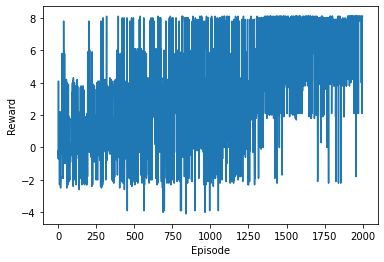

In [15]:
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

## Evaluation

Your model should be able to achieve the max possible sum of rewards.

In [16]:
def evaluate(dqn, config):
    
    dqn.q_net.eval()
    rewards = []  # to store the cumulative reward for each episode
    for _ in range(config['num_episodes_eval']):
        gamma = 1.
        total_reward = 0.
        
        # start a new episode
        state = dqn.env.reset()
        dqn.replay_buffer.store_frame(state)
        
        # while episode does not terminate
        while True:
            # get `frame_history_len` most recent frames
            # as an input observation to the Q-network
            q_input = dqn.replay_buffer.get_observation()
            q_input = torch.from_numpy(q_input).to(config['device']).float()
            
            # during evaluation, we always select the best action
            q_values = dqn.q_net(q_input)
            action = torch.argmax(q_values).item()
            
            # execute action and store transition
            new_state, reward, done, info = dqn.env.step(action)
            dqn.replay_buffer.store_effect(action, reward, done)
            state = new_state
            dqn.replay_buffer.store_frame(state)
            
            # cumulative reward
            total_reward += gamma * reward
            gamma *= config['gamma']
            
            if done:
                break
        
        # end of episode
        rewards.append(total_reward)
    
    avg_reward = np.mean(rewards)
    print(f'average reward: {avg_reward}')
    return avg_reward

In [17]:
avg_reward = evaluate(dqn, config)

average reward: 8.1
